In [1]:
!pip install innvestigate
!pip install "tensorflow>=1.15,<2.0"

In [2]:
%matplotlib inline

import imp
import keras.backend
import keras.models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle
import time
import keras

from keras.datasets import mnist
from keras.models import Model
from keras import optimizers

from matplotlib import cm, transforms

import innvestigate
import innvestigate.applications
import innvestigate.applications.mnist
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis
from innvestigate.utils.tests.networks import base as network_base

Using TensorFlow backend.


# Introduction

First, we obtain the dataset from the source as well as pretrained word embedding. Secondly, we prepare the dataset for training a neural network. Then, we construct a neural network model, receiving reviews as input and predicting their sentiments. Finally, we apply various explanation methods implemented in iNNvestigate to explain decisions from a trained model. The figure below is explanations of a review that we expect to see: red indicates a high relevance score in favour of the prediction, while blue is the opposite.

![][sample]

[arras]: http://www.aclweb.org/anthology/W16-1601
[arras2]: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0181142
[standford]: https://nlp.stanford.edu/sentiment/
[sample]: https://i.imgur.com/IRQL5oh.png

# Data Preparation

## Downloading The Dataset and Word Embedding

In the first step, we download the dataset from `http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip`.



In [3]:
%%bash
if [ ! -d "./stanfordSentimentTreebank" ]; then
    curl -L http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip -O && unzip stanfordSentimentTreebank.zip
else
    echo "The data is already there. Skip downloading!!"
fi

The data is already there. Skip downloading!!


As we are going to use an embedding layer as the first layer of our model, embedding weights are required. Fortuanately, there are pretrained word embedding available for this dataset, so we do not need to train it from scratch. The pre-trained embedding is provided by L. Arras at [LRP_for_LSTM][leila_lstm_repo]. Therefore, we can simply download the embedding weights and vocabulary files.
```
- https://github.com/ArrasL/LRP_for_LSTM/raw/master/model/embeddings.npy
- https://github.com/ArrasL/LRP_for_LSTM/raw/master/model/vocab
```

[leila_lstm_repo]: https://github.com/ArrasL/LRP_for_LSTM/tree/master/model

In [4]:
%%bash
if [ ! -e "./stanfordSentimentTreebank/embeddings.npy" ]; then
    curl -L https://github.com/ArrasL/LRP_for_LSTM/raw/master/model/embeddings.npy -o stanfordSentimentTreebank/embeddings.npy &&
        curl -L https://github.com/ArrasL/LRP_for_LSTM/raw/master/model/vocab -o stanfordSentimentTreebank/vocab
else
    echo "The data is already there. Skip downloading!!"
fi

The data is already there. Skip downloading!!


Lastly, due to an encoding issue in the dataset, we need to install the `ftfy` package for fixing the issue.

In [5]:
!pip install ftfy

In [6]:
from ftfy import fix_encoding

## Data Preprocessing

In [7]:
DATA_PATH = './stanfordSentimentTreebank'

In [8]:
with open('%s/vocab' % DATA_PATH, 'rb') as f:
    vocabs = pickle.load(f) 
    total_vocabs = len(vocabs) 

    # Unknown vocabs are set to <UNK>.
    encoder = dict(zip(['<UNK>'] + vocabs, range(0, len(vocabs) +1)))
    decoder = dict(zip(encoder.values(), encoder.keys()))
    
    print('We have %d vocabs.' % len(encoder))

We have 19539 vocabs.


In [9]:
pretrained_embedding = np.load('%s/embeddings.npy' % DATA_PATH)

# Unknown vocabs will have embedding weights of zero.
embedding = np.zeros((pretrained_embedding.shape[0]+1, pretrained_embedding.shape[1]))
embedding[1:, :] = pretrained_embedding

In [10]:
# load all necessary files
df_reviews = pd.read_csv('%s/datasetSentences.txt' % DATA_PATH, sep='\t')

df_reviews['phase'] = df_reviews.sentence.apply(lambda s: fix_encoding(s))\
    .apply(lambda s: s.replace('-LRB-', '(').replace('-RRB-', ')'))

df_reviews['sostr'] = pd.read_csv('%s/SOStr.txt' % DATA_PATH,
                                  sep='\t',encoding='utf-8',
                                  header=None, names=['sostr']
                                 )

df_reviews['splitset_label'] = pd.read_csv('%s/datasetSplit.txt' % DATA_PATH,
                                           sep=',', header=0
                                          )['splitset_label']


df_phases = pd.read_csv('%s/dictionary.txt' % DATA_PATH,
                        sep='|', names=['phase', 'phase_id']
                       )

df_sentiment_labels = pd.read_csv('%s/sentiment_labels.txt' % DATA_PATH,
                                  sep='|', names=['phase_id', 'sentiment_value'],
                                  header=0
                                 )

df_reviews_with_sentiment_value = df_reviews.merge(df_phases, how='inner', on=['phase'])\
    .merge(df_sentiment_labels, on='phase_id')

df_reviews_with_sentiment_value[:5]

,sentence_index,sentence,phase,sostr,splitset_label,phase_id,sentiment_value
0,1,The Rock is destined to be the 21st Century 's...,The Rock is destined to be the 21st Century 's...,The|Rock|is|destined|to|be|the|21st|Century|'s...,1,226166,0.69444
1,2,The gorgeously elaborate continuation of `` Th...,The gorgeously elaborate continuation of `` Th...,The|gorgeously|elaborate|continuation|of|``|Th...,1,226300,0.83333
2,3,Effective but too-tepid biopic,Effective but too-tepid biopic,Effective|but|too-tepid|biopic,2,13995,0.51389
3,4,If you sometimes like to go to the movies to h...,If you sometimes like to go to the movies to h...,If|you|sometimes|like|to|go|to|the|movies|to|h...,2,14123,0.73611
4,5,"Emerges as something rare , an issue movie tha...","Emerges as something rare , an issue movie tha...","Emerges|as|something|rare|,|an|issue|movie|tha...",2,13999,0.86111


Next, we need to decretize `sentiment_values` to labels. According to `./stanfordSentimentTreebank/README.md`, we should use the  below discretization scheme.

| Label | Sentiment Value Range |
|-------|-----------------------|
|   very_negative    |    [0, 0.2]                   |
|    negative   |         (0.2, 0.4]              |
|    neutral   |         (0.4, 0.6]               |
|    positive   |        (0.6, 0.8]               |
|    very_positive   |         (0.8, 1]               |



In [11]:
def sentiment_discretizer(sentiment_value):
    if 0 <= sentiment_value <= 0.2:
        return 'very_negative'
    elif 0.2 < sentiment_value <= 0.4:
        return 'negative'
    elif 0.4 < sentiment_value <= 0.6:
        return 'neutral'
    elif 0.6 < sentiment_value <= 0.8:
        return 'positive'
    elif 0.8 < sentiment_value <= 1:
        return 'very_positive'
    
df_reviews_with_sentiment_value['label'] = df_reviews_with_sentiment_value.sentiment_value.apply(sentiment_discretizer)

In [12]:
df_reviews_with_sentiment_value[:5]

,sentence_index,sentence,phase,sostr,splitset_label,phase_id,sentiment_value,label
0,1,The Rock is destined to be the 21st Century 's...,The Rock is destined to be the 21st Century 's...,The|Rock|is|destined|to|be|the|21st|Century|'s...,1,226166,0.69444,positive
1,2,The gorgeously elaborate continuation of `` Th...,The gorgeously elaborate continuation of `` Th...,The|gorgeously|elaborate|continuation|of|``|Th...,1,226300,0.83333,very_positive
2,3,Effective but too-tepid biopic,Effective but too-tepid biopic,Effective|but|too-tepid|biopic,2,13995,0.51389,neutral
3,4,If you sometimes like to go to the movies to h...,If you sometimes like to go to the movies to h...,If|you|sometimes|like|to|go|to|the|movies|to|h...,2,14123,0.73611,positive
4,5,"Emerges as something rare , an issue movie tha...","Emerges as something rare , an issue movie tha...","Emerges|as|something|rare|,|an|issue|movie|tha...",2,13999,0.86111,very_positive


In [13]:
len(df_reviews_with_sentiment_value)

11854

In [14]:
# mappings for Five-class Classification
LABEL_MAPPING = dict(zip(['very_negative', 'negative', 'neutral', 'positive', 'very_positive'], range(5)))
LABEL_IDX_TO_NAME = dict(zip(LABEL_MAPPING.values(), LABEL_MAPPING.keys()))

In [15]:
NUM_CLASSES = len(set(LABEL_MAPPING.values()))
print('We have %d classes.' % NUM_CLASSES)

We have 5 classes.


In [16]:
filtered_indices = df_reviews_with_sentiment_value.label.apply(lambda l: l in LABEL_MAPPING)

df_reviews_with_sentiment_value_filtered = df_reviews_with_sentiment_value.loc[filtered_indices].copy()
df_reviews_with_sentiment_value_filtered.loc[:, 'label_idx'] = df_reviews_with_sentiment_value_filtered.label\
    .apply(lambda l: LABEL_MAPPING[l])

df_reviews_with_sentiment_value_filtered[:5]

,sentence_index,sentence,phase,sostr,splitset_label,phase_id,sentiment_value,label,label_idx
0,1,The Rock is destined to be the 21st Century 's...,The Rock is destined to be the 21st Century 's...,The|Rock|is|destined|to|be|the|21st|Century|'s...,1,226166,0.69444,positive,3
1,2,The gorgeously elaborate continuation of `` Th...,The gorgeously elaborate continuation of `` Th...,The|gorgeously|elaborate|continuation|of|``|Th...,1,226300,0.83333,very_positive,4
2,3,Effective but too-tepid biopic,Effective but too-tepid biopic,Effective|but|too-tepid|biopic,2,13995,0.51389,neutral,2
3,4,If you sometimes like to go to the movies to h...,If you sometimes like to go to the movies to h...,If|you|sometimes|like|to|go|to|the|movies|to|h...,2,14123,0.73611,positive,3
4,5,"Emerges as something rare , an issue movie tha...","Emerges as something rare , an issue movie tha...","Emerges|as|something|rare|,|an|issue|movie|tha...",2,13999,0.86111,very_positive,4


## Spiting Training, Testing, and Validation Set.

In [17]:
SPLIT_LABEL_MAPPING = {
    'training' : 1,
    'testing': 2,
    'validation': 3
}

MAX_SEQ_LENGTH = 40
EMBEDDING_DIM = embedding.shape[1]

In [18]:
## vectorize words in train, test, val splits
def prepare_dataset(ds):
    ''' ds - takes one of the following values: training, testing, validation '''

    filtered_indices = df_reviews_with_sentiment_value_filtered.splitset_label == SPLIT_LABEL_MAPPING[ds] # indices that belong to this split
    
    reviews_in_ds = df_reviews_with_sentiment_value_filtered[filtered_indices] # get all reviews corresponding to the filtered indices
    
    xd = np.zeros((len(reviews_in_ds), MAX_SEQ_LENGTH, EMBEDDING_DIM)) # create a np matrix for input to embedding layer
    y = reviews_in_ds.label_idx.values.astype(int)
    
    reviews = []
    for i, sostr in enumerate(reviews_in_ds.sostr.values):
        # sostr = Starts|out|ballsy|and|stylish|but|fails|to|keep|it|up|and|settles|into|clichés|.
        sostr = sostr.lower()
        review = []
        for j, v in enumerate(sostr.split('|')[:MAX_SEQ_LENGTH]):
            if v in encoder: # encoder - word2id map
                e_idx = encoder[v]
            else:
                e_idx = 0
            
            xd[i, j, :] = embedding[e_idx]
            review.append(e_idx)
        reviews.append(review)
        

    return dict(
        x4d=np.expand_dims(xd, axis=1), # embedding
        y=y, # label
        encoded_reviews=reviews # word-ids corresponding to each word in the review
    )
    

DATASETS = dict()

for ds in ['training', 'testing', 'validation']:
    DATASETS[ds] = prepare_dataset(ds)


In [19]:
len(df_reviews_with_sentiment_value), len(df_reviews_with_sentiment_value_filtered)

(11854, 11854)

In [20]:
print('We have %d reviews in the training set, and %d reviews in the testing set' % 
      (len(DATASETS['training']['x4d']), len(DATASETS['testing']['x4d']))
     )

We have 8543 reviews in the training set, and 2210 reviews in the testing set


In [21]:
sample_idx = 1225

print('Review(ID=%d): %s' %
      (sample_idx, ' '.join(map(lambda x: decoder[x], DATASETS['training']['encoded_reviews'][sample_idx]))))

Review(ID=1225): filmmaker stacy peralta has a flashy editing style that does n't always jell with sean penn 's monotone narration , but he respects the material without sentimentalizing it .


# Model Construction

Our classifier is a convolutional neural network, which was experimented in [Arras et al. (2017b)][arras2]. As shown below, the architecture has a convoluationa layer, convolving word embeddings of every two words, followed by a max pooling layer and a softmax layer.

![][arch]

[arch]: https://i.imgur.com/YQDfS5P.png
[arras2]: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0181142

In [22]:
def build_network(input_shape, output_n, activation=None, dense_unit=256, dropout_rate=0.25):
    if activation:
        activation = "relu"

    net = {}
    net["in"] = network_base.input_layer(shape=input_shape)
    net["conv"] = keras.layers.Conv2D(filters=100, kernel_size=(1,2), strides=(1, 1), padding='valid')(net["in"])
    net["pool"] = keras.layers.MaxPooling2D(pool_size=(1, input_shape[2]-1), strides=(1,1))(net["conv"])
    net["out"] = network_base.dense_layer(keras.layers.Flatten()(net["pool"]), units=5, activation=activation)
    net["sm_out"] = network_base.softmax(net["out"])


    net.update({
        "input_shape": input_shape,

        "output_n": output_n,
    })
    return net

net = build_network((None, 1, MAX_SEQ_LENGTH, EMBEDDING_DIM), NUM_CLASSES)

model_without_softmax, model_with_softmax = Model(inputs=net['in'], outputs=net['out']), Model(inputs=net['in'], outputs=net['sm_out'])

In [32]:
def to_one_hot(y):
    return keras.utils.to_categorical(y, NUM_CLASSES)

def train_model(model,  batch_size=128, epochs=20):
    
    x_train = DATASETS['training']['x4d']
    y_train = to_one_hot(DATASETS['training']['y'])
    
    x_test = DATASETS['testing']['x4d']
    y_test = to_one_hot(DATASETS['testing']['y'])
    
    x_val = DATASETS['validation']['x4d']
    y_val = to_one_hot(DATASETS['validation']['y'])
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(),
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_val, y_val),
                        shuffle=True
                       )
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

In [41]:
train_model(model_with_softmax, batch_size=256, epochs=20)

Train on 8543 samples, validate on 1101 samples
Epoch 1/20
8543/8543 [==============================] - 2s 272us/step - loss: 1.0066 - acc: 0.5785 - val_loss: 1.2951 - val_acc: 0.4296
Epoch 2/20
8543/8543 [==============================] - 1s 113us/step - loss: 0.9974 - acc: 0.5820 - val_loss: 1.2969 - val_acc: 0.4142
Epoch 3/20
8543/8543 [==============================] - 1s 109us/step - loss: 0.9918 - acc: 0.5861 - val_loss: 1.2949 - val_acc: 0.4187
Epoch 4/20
8543/8543 [==============================] - 1s 99us/step - loss: 0.9848 - acc: 0.5893 - val_loss: 1.3009 - val_acc: 0.4260
Epoch 5/20
8543/8543 [==============================] - 1s 111us/step - loss: 0.9785 - acc: 0.5939 - val_loss: 1.2979 - val_acc: 0.4314
Epoch 6/20
8543/8543 [==============================] - 1s 98us/step - loss: 0.9709 - acc: 0.5925 - val_loss: 1.2990 - val_acc: 0.4260
Epoch 7/20
8543/8543 [==============================] - 1s 101us/step - loss: 0.9656 - acc: 0.6010 - val_loss: 1.3046 - val_acc: 0.4305
Ep

In [42]:
model_without_softmax.set_weights(model_with_softmax.get_weights())

# Model Analysis and Visualization

At this stage, we have a trained model and are ready to explain it via **iNNvestigate**'s analyzers.

In [43]:
# Specify methods that you would like to use to explain the model. 
# Please refer to iNNvestigate's documents for available methods.
methods = ['gradient', 'lrp.z', 'lrp.alpha_2_beta_1']
kwargs = [{}, {}, {}, {'pattern_type': 'relu'}]

In [44]:
# build an analyzer for each method
analyzers = []

for method, kws in zip(methods, kwargs):
    analyzer = innvestigate.create_analyzer(method, model_without_softmax, **kws)
    analyzer.fit(DATASETS['training']['x4d'], batch_size=256, verbose=1)
    analyzers.append(analyzer)

/usr/local/lib/python3.7/dist-packages/innvestigate/analyzer/base.py:130: RuntimeWarning: This analyzer does not need to be trained. Still fit() is called.
  " Still fit() is called.", RuntimeWarning)


In [45]:
# specify indices of reviews that we want to investigate
test_sample_indices = [50, 105, 30, 23, 500, 777]

test_sample_preds = [None]*len(test_sample_indices)

# a variable to store analysis results.
analysis = np.zeros([len(test_sample_indices), len(analyzers), 1, MAX_SEQ_LENGTH])

for i, ridx in enumerate(test_sample_indices):

    x, y = DATASETS['testing']['x4d'][ridx], DATASETS['testing']['y'][ridx]

    t_start = time.time()
    x = x.reshape((1, 1, MAX_SEQ_LENGTH, EMBEDDING_DIM))    

    presm = model_without_softmax.predict_on_batch(x)[0] #forward pass without softmax
    prob = model_with_softmax.predict_on_batch(x)[0] #forward pass with softmax
    y_hat = prob.argmax()
    test_sample_preds[i] = y_hat
    
    for aidx, analyzer in enumerate(analyzers):

        a = np.squeeze(analyzer.analyze(x))
        a = np.sum(a, axis=1)

        analysis[i, aidx] = a
    t_elapsed = time.time() - t_start
    print('Review %d (%.4fs)'% (ridx, t_elapsed))

Review 50 (1.2143s)
Review 105 (0.0047s)
Review 30 (0.0039s)
Review 23 (0.0040s)
Review 500 (0.0045s)
Review 777 (0.0039s)


## Visualization

To this point, we have all analysis results from iNNvestigate's analyzers, and we are now ready to visualize them in a insightful way. We will use relevance scores from explanation methods to highlight the words in each review. 

We will use  the *blue-white-red (bwr)* color map for this purpose. Hence, words that have a positive score to the prediction are be shaded in *red*, while  negative-contribution or zero-contribution words are then highlighted in *blue*, and *white*, respectively.


In [49]:
# This is a utility method visualizing the relevance scores of each word to the network's prediction. 
# one might skip understanding the function, and see its output first.
def plot_text_heatmap(words, scores, title="", width=10, height=0.2, verbose=0, max_word_per_line=20):
    fig = plt.figure(figsize=(width, height))
    
    ax = plt.gca()

    ax.set_title(title, loc='left')
    tokens = words
    if verbose > 0:
        print('len words : %d | len scores : %d' % (len(words), len(scores)))

    cmap = plt.cm.ScalarMappable(cmap=cm.bwr)
    cmap.set_clim(0, 1)
    
    canvas = ax.figure.canvas
    t = ax.transData

    # normalize scores to the followings:
    # - negative scores in [0, 0.5]
    # - positive scores in (0.5, 1]
    normalized_scores = 0.5 * scores / np.max(np.abs(scores)) + 0.5
    
    if verbose > 1:
        print('Raw score')
        print(scores)
        print('Normalized score')
        print(normalized_scores)

    # make sure the heatmap doesn't overlap with the title
    loc_y = -0.2

    for i, token in enumerate(tokens):
        *rgb, _ = cmap.to_rgba(normalized_scores[i], bytes=True)
        color = '#%02x%02x%02x' % tuple(rgb)
        
        text = ax.text(0.0, loc_y, token,
                       bbox={
                           'facecolor': color,
                           'pad': 5.0,
                           'linewidth': 1,
                           'boxstyle': 'round,pad=0.5'
                       }, transform=t)

        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        
        # create a new line if the line exceeds the length
        if (i+1) % max_word_per_line == 0:
            loc_y = loc_y -  2.5
            t = ax.transData
        else:
            t = transforms.offset_copy(text._transform, x=ex.width+15, units='dots')

    if verbose == 0:
        ax.axis('off')

Review(id=50): an engaging overview of johnson 's eccentric career .
Pred class : positive ✓


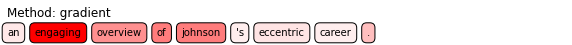

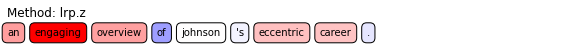

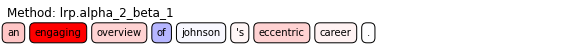

Review(id=105): the film is often filled with a sense of pure wonderment and excitement not often seen in today 's cinema du sarcasm
Pred class : positive ✗ (very_positive)


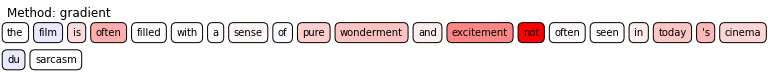

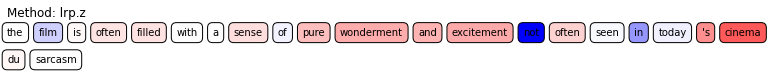

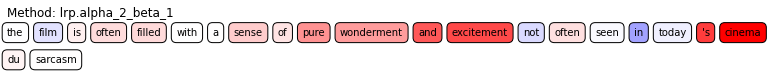

Review(id=30): a masterful film from a master filmmaker , unique in its deceptive grimness , compelling in its fatalist worldview .
Pred class : very_positive ✓


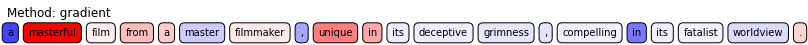

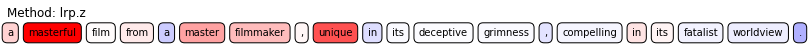

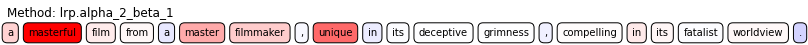

Review(id=23): scores a few points for doing what it does with a dedicated and good-hearted professionalism .
Pred class : positive ✓


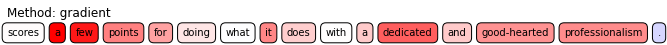

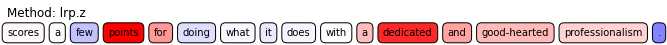

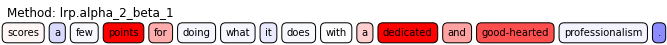

Review(id=500): this is a very fine movie -- go see it .
Pred class : very_positive ✓


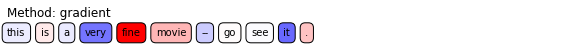

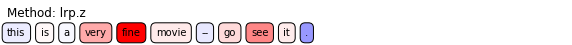

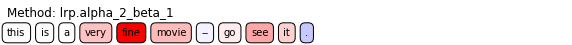

Review(id=777): it 's predictable , but it jumps through the expected hoops with style and even some depth .
Pred class : neutral ✗ (positive)


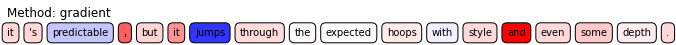

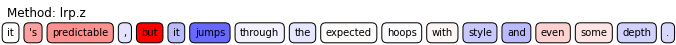

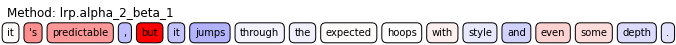

In [50]:
# Traverse over the analysis results and visualize them.

for i, idx in enumerate(test_sample_indices):

    words = [decoder[t] for t in list(DATASETS['testing']['encoded_reviews'][idx])]
    
    print('Review(id=%d): %s' % (idx, ' '.join(words)))
    y_true = DATASETS['testing']['y'][idx]
    y_pred = test_sample_preds[i]

    print("Pred class : %s %s" %
          (LABEL_IDX_TO_NAME[y_pred], '✓' if y_pred == y_true else '✗ (%s)' % LABEL_IDX_TO_NAME[y_true])
         )
                                
    for j, method in enumerate(methods):
        plot_text_heatmap(words, analysis[i, j].reshape(-1), title='Method: %s' % method, verbose=0)
        plt.savefig(f'cnn_heatmap{i}_{j}.png',  bbox_inches = 'tight')
        plt.show()
        

In [48]:
# from google.colab import files

# for i in range(3):
#   for j in range(3):
#     files.download(f'cnn_heatmap{i}_{j}.png')